In [1]:
# The relevant libraries have been activated
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


In [2]:
insurance  = pd.read_csv("/content/insurance.csv") # Data reading has been performed
df = insurance.copy() # We are making a copy to preserve the original data

PERFORM AN EXPLORATORY DATA ANALYSIS

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### DESCRIBE #####################")  # statistical summary
    print(dataframe.describe().T)
    print("##################### Quantiles #####################")
    numeric_columns = dataframe.select_dtypes(include=['number'])
    if not numeric_columns.empty:
        print(numeric_columns.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df) # data overview

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
##################### Tail #####################
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629

In [5]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    """
    Provides the names of categorical, numeric, and categorical but cardinal variables in the dataset.
    Note: Numeric-looking categorical variables are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be taken
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optinal
                Class threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                List of categorical variables
        num_cols: list
                List of numeric variables
        cat_but_car: list
                List of categorical-looking cardinal variables

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is within cat_cols.
        The sum of the 3 lists returned is equal to the total number of variables:
        cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df) # Let's use the 'grab_col_names' function to examine the categories of our variables and classify them.


Observations: 1338
Variables: 7
cat_cols: 3
num_cols: 4
cat_but_car: 0
num_but_cat: 0


        sex      Ratio
male    676  50.523169
female  662  49.476831
##########################################


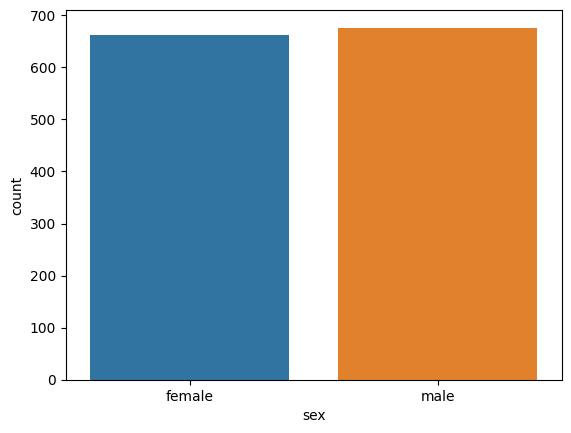

     smoker      Ratio
no     1064  79.521674
yes     274  20.478326
##########################################


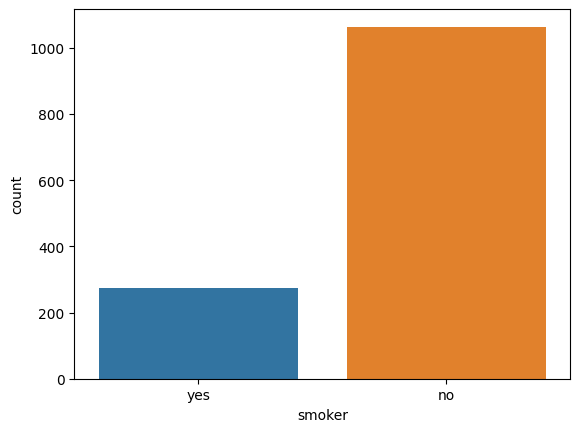

           region      Ratio
southeast     364  27.204783
southwest     325  24.289985
northwest     325  24.289985
northeast     324  24.215247
##########################################


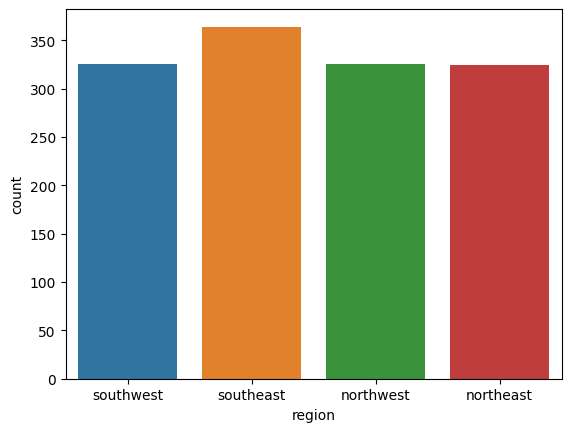

In [7]:
# ANALYSIS OF CATEGORICAL VARIABLES
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
for col in cat_cols:
    cat_summary(df, col, plot=True)

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
5%         18.000000
10%        19.000000
20%        24.000000
30%        29.000000
40%        34.000000
50%        39.000000
60%        44.000000
70%        49.000000
80%        54.000000
90%        59.000000
95%        62.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64


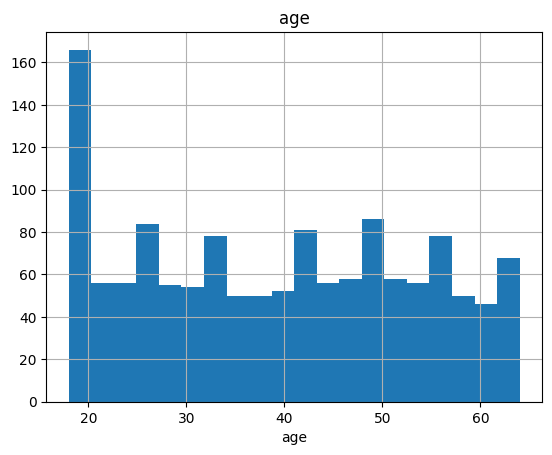

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64


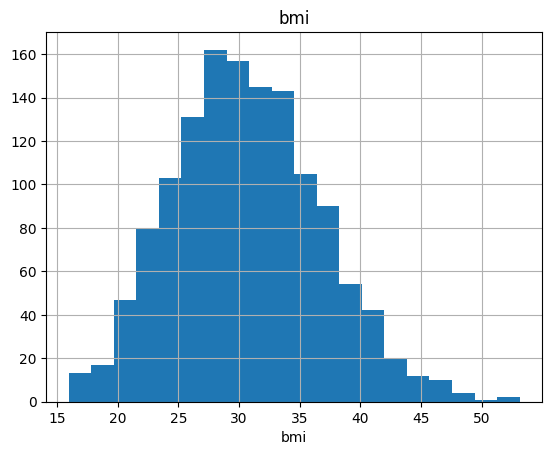

count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         1.000000
60%         1.000000
70%         2.000000
80%         2.000000
90%         3.000000
95%         3.000000
99%         5.000000
max         5.000000
Name: children, dtype: float64


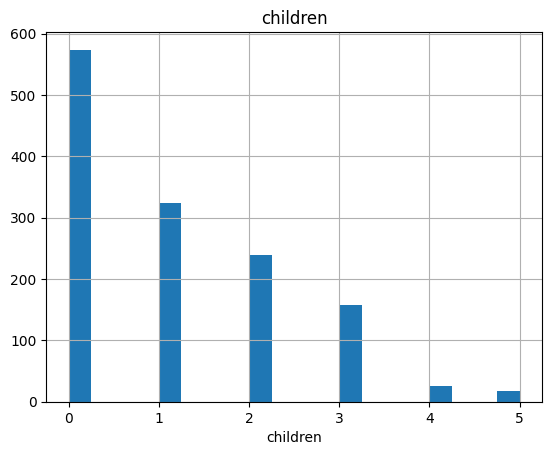

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
5%        1757.753400
10%       2346.533615
20%       3991.575720
30%       5484.846770
40%       7369.052730
50%       9382.033000
60%      11399.857160
70%      13767.875345
80%      20260.626406
90%      34831.719700
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64


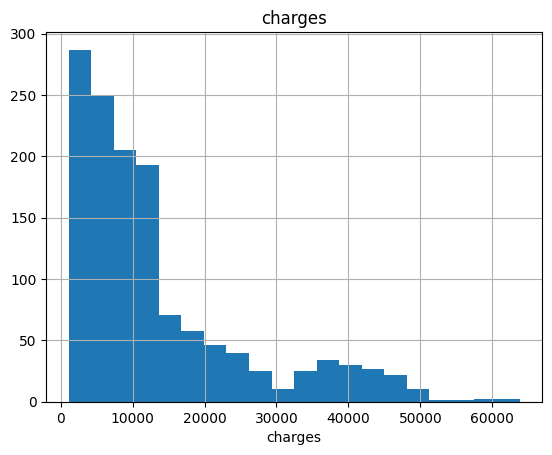

In [ ]:
# ANALYSIS OF NUMERICAL VARIABLES
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

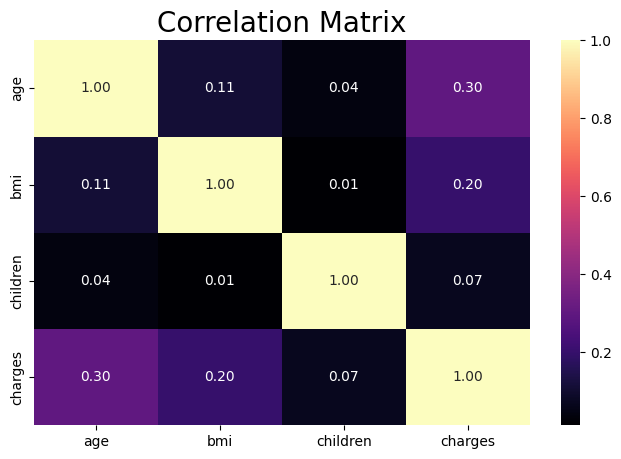

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
dtype: float64

In [ ]:
# Correlation Matrix
f, ax = plt.subplots(figsize=[8, 5])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block=True)

df[num_cols].corrwith(df["charges"]).sort_values(ascending=False)

BMI DISTRIBUTION

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64


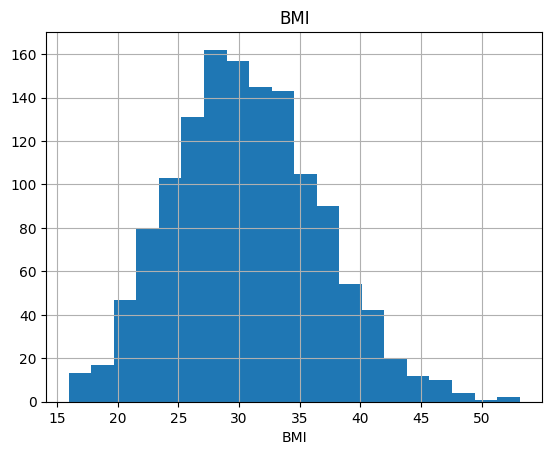

In [ ]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df["bmi"].describe(quantiles).T)
df["bmi"].hist(bins=20)
plt.xlabel("BMI")
plt.title("BMI")
plt.show()

RELATIONSHIP BETWEEN SMOKER AND CHARGES



• According to the table, it is evident that the expenses of smokers
are significantly higher compared to non-smokers.

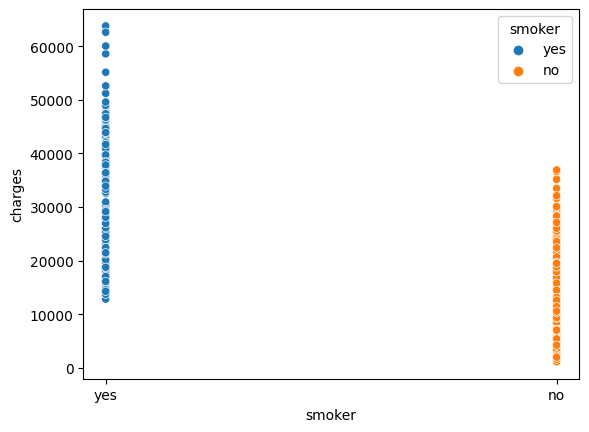

             charges
smoker              
no       8434.268298
yes     32050.231832


In [ ]:
sns.scatterplot(x=df["smoker"],y=df["charges"],
                hue=df["smoker"], data=df)
plt.show()

print(df.groupby("smoker").agg({"charges": "mean"}))

RELATIONSHIP BETWEEN SMOKER AND REGION

• The region with the highest number of both smokers and non-smokers is the Southeast region.

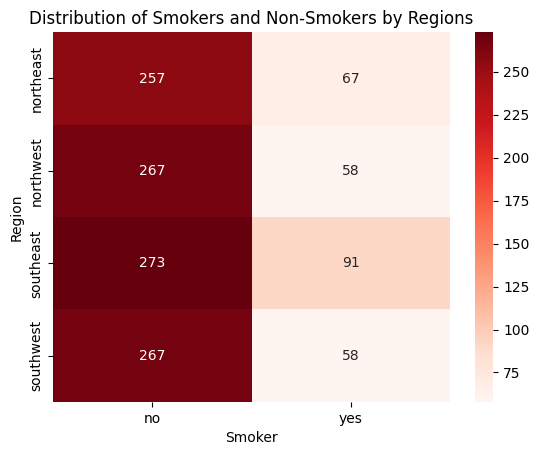

In [ ]:
sns.heatmap( df.groupby(['region', 'smoker']).size().unstack()
, annot=True, fmt='g', cmap='Reds')
plt.title('Distribution of Smokers and Non-Smokers by Regions')
plt.xlabel('Smoker')
plt.ylabel('Region')
plt.show()

RELATIONSHIP BETWEEN BMI AND SEX

• It is observed that the BMI of males is higher than females.

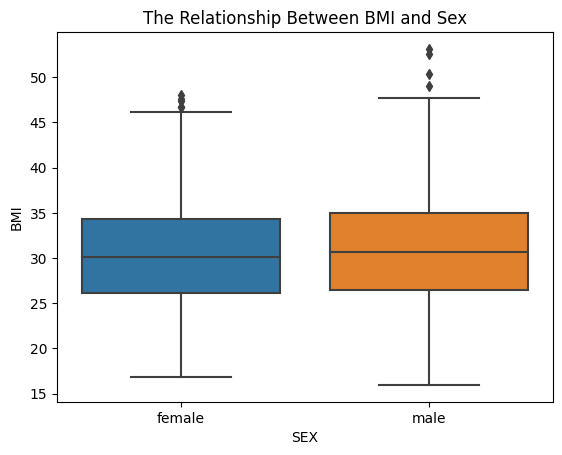

In [ ]:
sns.boxplot(x='sex', y='bmi', data=df)
plt.title('The Relationship Between BMI and Sex')
plt.xlabel('SEX')
plt.ylabel('BMI')
plt.show()


REGION WITH THE MOST CHILDREN

In [ ]:
child_counts = df.groupby('region')['children'].sum()

# Region with the highest number of children
most_children_region = child_counts.idxmax()
most_children_count = child_counts.max()

print(f"The region with the highest number of children: {most_children_region}")
print(f"Total number of children: {most_children_count}")


The region with the highest number of children: southeast
Total number of children: 382


RELATIONSHIP BETWEEN AGE AND BMI

• The distribution of BMI by age is uneven.

           bmi
age           
18   31.326159
19   28.596912
20   30.632759
21   28.185714
22   31.087679
23   31.454464
24   29.142679
25   29.693929
26   29.428929
27   29.333571
28   29.482143
29   29.383148
30   30.557593
31   29.918333
32   31.597692
33   31.163077
34   30.274038
35   31.394800
36   29.374200
37   31.216600
38   28.996600
39   29.910200
40   30.139074
41   31.506852
42   30.328148
43   30.204444
44   30.844259
45   29.778966
46   31.340862
47   30.664310
48   31.925690
49   30.313929
50   31.132241
51   31.727069
52   32.936034
53   30.360893
54   31.234286
55   31.950000
56   31.600962
57   30.844423
58   32.718200
59   30.572000
60   30.332826
61   32.548261
62   32.342609
63   31.923478
64   32.976136


Text(0.5, 1.0, 'Average BMIs by Age Groups')

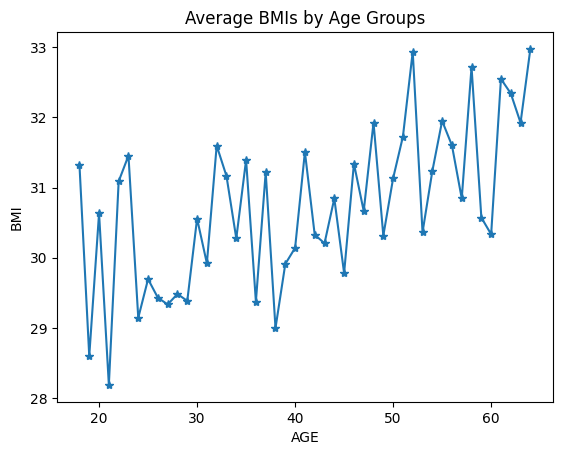

In [ ]:
print(df.groupby("age").agg({"bmi": "mean"}))

age_bmi=df.groupby("age")["bmi"].mean()
plt.plot(age_bmi.index,age_bmi.values,marker="*")
plt.xlabel("AGE")
plt.ylabel("BMI")
plt.title("Average BMIs by Age Groups")

RELATIONSHIP BETWEEN BMI AND CHILDREN

• According to the graph, individuals with 4 children have the highest average BMI compared to the others, yet they are still quite close to each other

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

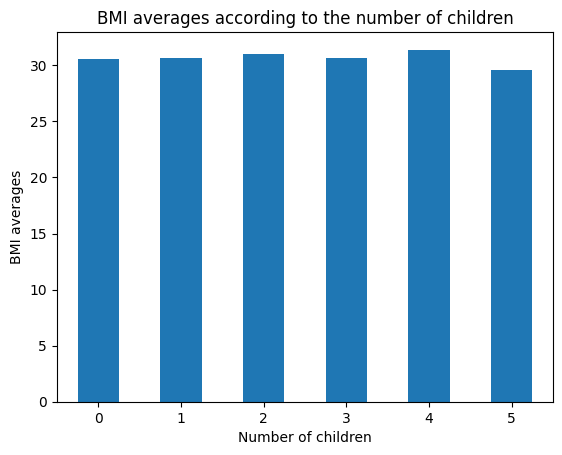

In [ ]:
df.groupby("children")["bmi"].mean().plot(kind="bar")
plt.xlabel("Number of children")
plt.ylabel("BMI averages")
plt.title("BMI averages according to the number of children")
plt.xticks(rotation=360)

OUTLIER DECECTION IN THE BMI VARIBLE

In [ ]:
# Are there any outliers in the "bmi" variable?


def outlier_thresholds(df, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(df, col_name):
  low_limit, up_limit = outlier_thresholds(df, col_name)
  if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
      return True
  else:
      return False

check_outlier(df, "bmi") # Since it's True, there are outliers present.

True

RELATIONSHIP BETWEEN CHARGES AND BMI

• By looking at the graph, we can say that this graph is irregular.



<Axes: xlabel='bmi', ylabel='charges'>

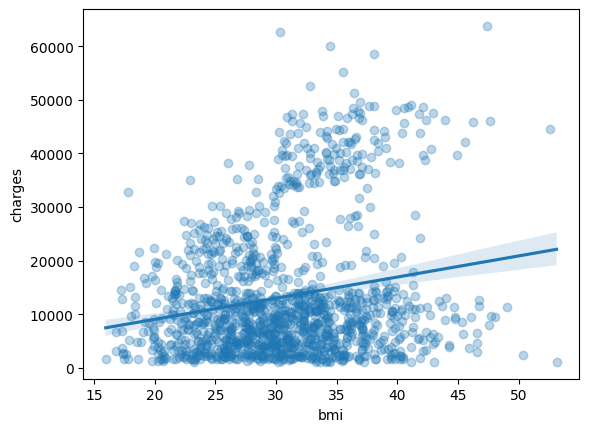

In [ ]:
sns.regplot(x='bmi', y='charges', data=df, scatter_kws={'alpha':0.3})


RELATIONSHIP BETWEEN SMOKER , BMI AND REGION

• The region with the highest number of both smokers and non-smokers is the Southeast region. Additionally, the Southeast region has a higher average BMI compared to the others

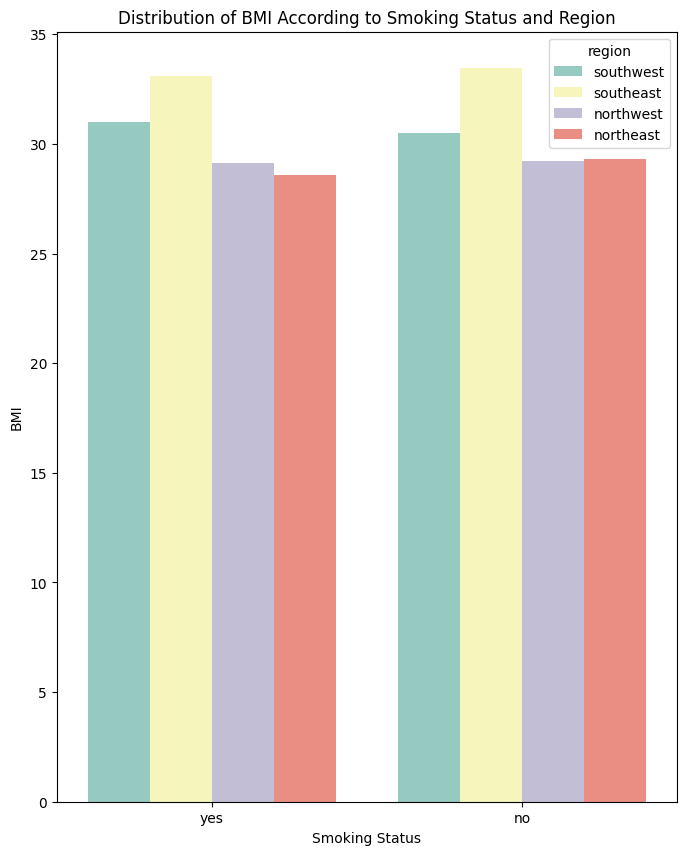

In [ ]:
plt.figure(figsize=(8, 10))
sns.barplot(x='smoker', y='bmi', hue='region', data=df, ci=None, palette='Set3')
plt.title('Distribution of BMI According to Smoking Status and Region')
plt.xlabel('Smoking Status')
plt.ylabel('BMI')
plt.show()

DATA PREPROCESSING

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df) # Let's see our variables again

print(cat_cols, num_cols, cat_but_car)
# Remove "charges" from num_cols list
num_cols = [col for col in num_cols if col != "charges"]

print(num_cols)

Observations: 1338
Variables: 7
cat_cols: 3
num_cols: 4
cat_but_car: 0
num_but_cat: 0
['sex', 'smoker', 'region'] ['age', 'bmi', 'children', 'charges'] []
['age', 'bmi', 'children']


In [9]:
# Let's check if there are any outliers.

def outlier_thresholds(df, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(df, col_name):
  low_limit, up_limit = outlier_thresholds(df, col_name)
  if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
      return True
  else:
      return False

for col in num_cols:
    if check_outlier(df, col):
        print(f"Outliers present: {col}")
    else:
        print(f"No outliers: {col}")

No outliers: age
Outliers present: bmi
No outliers: children


OUTLIER SUPPRESSION

In [10]:
# Outlier suppression process
def outlier_thresholds(df, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
  replace_with_thresholds(df, col)

CHECKING THE SUPPRESSION

In [11]:
# Let's check if the suppression was successful.

def check_outlier(df, col_name):
  low_limit, up_limit = outlier_thresholds(df, col_name)
  if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
      return True
  else:
      return False

for col in num_cols:
  print(check_outlier(df, col))  # All are False, no outliers are present, suppression successful.

False
False
False


In [12]:
# New variables have been created.

df["NEW_BMI_RANGE"] = pd.cut(x=df["bmi"], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healthy", "overweight", "obese"])

df.loc[(df["age"] < 25), "NEW_AGE_CAT"] = "young"
df.loc[(df["age"] >= 25) & (df["age"] <= 50), "NEW_AGE_CAT"] = "middleage"
df.loc[(df["age"] > 50), "NEW_AGE_CAT"] = "old"

df.loc[(df["bmi"] >= 25) & (df["smoker"] == "yes"), "NEW_BMI_SMOKER"] = "high_bmi_smoker"
df.loc[(df["bmi"] >= 25) & (df["smoker"] == "no"), "NEW_BMI_SMOKER"] = "high_bmi_no_smoker"
df.loc[(df["bmi"] < 25) & (df["smoker"] == "no"), "NEW_BMI_SMOKER"] = "normal_bmi_no_smoker"
df.loc[(df["bmi"] < 25) & (df["smoker"] == "yes"), "NEW_BMI_SMOKER"] = "normal_bmi_smoker"


In [13]:
# Let's check if there's any issue with the variables (missing values, etc.).
check_df(df)

# Let's examine our variables.
print("--------------------------------------------")
cat_cols, num_cols, cat_but_car = grab_col_names(df)

##################### Shape #####################
(1338, 10)
##################### Types #####################
age                  int64
sex                 object
bmi                float64
children             int64
smoker              object
region              object
charges            float64
NEW_BMI_RANGE     category
NEW_AGE_CAT         object
NEW_BMI_SMOKER      object
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges NEW_BMI_RANGE  \
0   19  female  27.900         0    yes  southwest  16884.92400    overweight   
1   18    male  33.770         1     no  southeast   1725.55230         obese   
2   28    male  33.000         3     no  southeast   4449.46200         obese   
3   33    male  22.705         0     no  northwest  21984.47061       healthy   
4   32    male  28.880         0     no  northwest   3866.85520    overweight   

  NEW_AGE_CAT        NEW_BMI_SMOKER  
0       young       high_bmi_sm

In [14]:
# label encoding

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols=[col for col in df.columns if df[col].dtype not in [int,float] and df[col].nunique()==2]
print(binary_cols)

for col in binary_cols:
    df=label_encoder(df,col)

['sex', 'smoker']


In [15]:
# Let's apply one hot encode to the region categorical variable
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [16]:
df.info() # checking process

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   age                                  1338 non-null   int64  
 1   bmi                                  1338 non-null   float64
 2   children                             1338 non-null   int64  
 3   charges                              1338 non-null   float64
 4   sex_1                                1338 non-null   uint8  
 5   smoker_1                             1338 non-null   uint8  
 6   region_northwest                     1338 non-null   uint8  
 7   region_southeast                     1338 non-null   uint8  
 8   region_southwest                     1338 non-null   uint8  
 9   NEW_AGE_CAT_old                      1338 non-null   uint8  
 10  NEW_AGE_CAT_young                    1338 non-null   uint8  
 11  NEW_BMI_SMOKER_high_bmi_smoker

In [17]:
X = df.drop("charges", axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

MODEL SELECTION



In [18]:
classifiers = [("LR", LinearRegression()),
               ("Ridge", Ridge()),
               ("Lasso", Lasso()),
               ("ElasticNet", ElasticNet()),
               ("KNN", KNeighborsRegressor()),
               ("CART", DecisionTreeRegressor()),
               ("RF", RandomForestRegressor()),
               ("SVR", SVR()),
               ("GBM", GradientBoostingRegressor()),
               ("XGBoost", XGBRegressor(objective='reg:squarederror'))]

best_model = None
best_rmse = float('inf')

# Let's evaluate each model individually.
for name, regressor in classifiers:
    rmse_scores = np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=10, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring="r2")


    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)

    print(f"Model: {name}")
    print(f"Average RMSE: {round(avg_rmse, 4)}")
    print(f"Average R2 Score: {round(avg_r2, 4)}")
    print("-------------------------")

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model = regressor

print("Best Performing Model:", best_model) # According to the RMSE value

Model: LR
Average RMSE: 5524.65
Average R2 Score: 0.7785
-------------------------
Model: Ridge
Average RMSE: 5525.6103
Average R2 Score: 0.7784
-------------------------
Model: Lasso
Average RMSE: 5526.023
Average R2 Score: 0.7783
-------------------------
Model: ElasticNet
Average RMSE: 8454.4933
Average R2 Score: 0.4972
-------------------------
Model: KNN
Average RMSE: 10467.0406
Average R2 Score: 0.2279
-------------------------
Model: CART
Average RMSE: 6955.7655
Average R2 Score: 0.6624
-------------------------
Model: RF
Average RMSE: 5012.4345
Average R2 Score: 0.8181
-------------------------
Model: SVR
Average RMSE: 12558.3299
Average R2 Score: -0.1032
-------------------------
Model: GBM
Average RMSE: 4661.0858
Average R2 Score: 0.8417
-------------------------
Model: XGBoost
Average RMSE: 5263.6392
Average R2 Score: 0.7994
-------------------------
Best Performing Model: GradientBoostingRegressor()


HYPER-PARAMETERS OPTIMIZATION

In [19]:
# A hyperparameters table is defined for the GBM model
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Let's perform GridSearchCV to find the best hyperparameters.

grid_search = GridSearchCV(best_model, param_grid, cv=10, scoring=make_scorer(mean_squared_error, greater_is_better=False))
grid_search.fit(X_train_scaled, y_train)

# The best model obtained with optimized hyperparameters
best_model_with_hyperparams = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE after Hyper-parameter Optimization:", np.sqrt(-grid_search.best_score_))

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best RMSE after Hyper-parameter Optimization: 4619.511471434914


MODEL EVALUATION

In [20]:
# Make predictions using the best model
y_pred_hyperparams = best_model_with_hyperparams.predict(X_test_scaled)

# Calculate evaluation metrics after hyper-parameter optimization
mse = mean_squared_error(y_test, y_pred_hyperparams)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_hyperparams)
r2 = r2_score(y_test, y_pred_hyperparams)

# Print the results after hyper-parameter optimization
print("Results after Hyper-parameter Optimization:")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

Results after Hyper-parameter Optimization:
RMSE: 4430.049479150393
MSE: 19625338.38772067
MAE: 2680.409925634905
R2 Score: 0.8735877697734322
